In [54]:
#Thư viện
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

In [55]:
#chỉ số
INPUT_SIZE = [224,224]
BATCH = 16

In [56]:
#Tạo data để train
training_datagen = ImageDataGenerator(rescale=1./255,
                                      shear_range=0.2,
                                      zoom_range = 0.2,
                                      )

training_data = training_datagen.flow_from_directory('./Train',
                                                     target_size = INPUT_SIZE,
                                                     batch_size=BATCH,
                                                     class_mode = 'categorical'
                                                     )

Found 13278 images belonging to 3 classes.


In [57]:
label_order = training_data.class_indices
print(label_order)

{'IncorrectMask': 0, 'WithMask': 1, 'WithoutMask': 2}


In [58]:
#Tạo data để test
test_datagen = ImageDataGenerator(rescale=1./255)

test_data = training_datagen.flow_from_directory('./Test',
                                                     target_size = INPUT_SIZE,
                                                     batch_size=BATCH,
                                                     class_mode = 'categorical'
                                                     )

Found 1647 images belonging to 3 classes.


Sử dụng VGG16 để train model

In [59]:
#Sử dụng VGG16
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

In [60]:
vgg16 = VGG16(input_shape=INPUT_SIZE + [3], weights='imagenet', include_top=False)

In [61]:
for layer in vgg16.layers:
    layer.trainable = False

In [62]:
flatten = Flatten()(vgg16.output)
dense = Dense(units=256, activation='relu')(flatten)
dense_output = Dense(units=3, activation='softmax')(dense)

In [63]:
model = Model(inputs=vgg16.input, outputs=dense_output)

In [64]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)

In [65]:
r = model.fit(
  training_data,
  validation_data=test_data,
  epochs=10,
  steps_per_epoch=len(training_data),
  validation_steps=len(test_data)
)

Epoch 1/10
830/830 [==============================] - 152s 181ms/step - loss: 0.2943 - accuracy: 0.9587 - val_loss: 0.0817 - val_accuracy: 0.9787
Epoch 2/10
830/830 [==============================] - 123s 149ms/step - loss: 0.0661 - accuracy: 0.9856 - val_loss: 0.0490 - val_accuracy: 0.9909
Epoch 3/10
830/830 [==============================] - 122s 146ms/step - loss: 0.0520 - accuracy: 0.9890 - val_loss: 0.0708 - val_accuracy: 0.9860
Epoch 4/10
830/830 [==============================] - 123s 148ms/step - loss: 0.0363 - accuracy: 0.9923 - val_loss: 0.0401 - val_accuracy: 0.9951
Epoch 5/10
830/830 [==============================] - 124s 149ms/step - loss: 0.0459 - accuracy: 0.9923 - val_loss: 0.0631 - val_accuracy: 0.9927
Epoch 6/10
830/830 [==============================] - 123s 148ms/step - loss: 0.0348 - accuracy: 0.9942 - val_loss: 0.0527 - val_accuracy: 0.9957
Epoch 7/10
830/830 [==============================] - 123s 148ms/step - loss: 0.0370 - accuracy: 0.9941 - val_loss: 0.0507 -

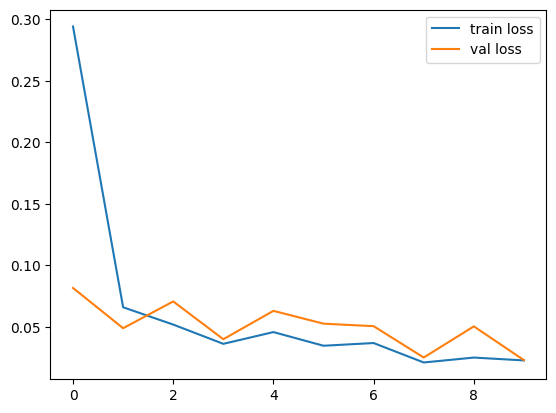

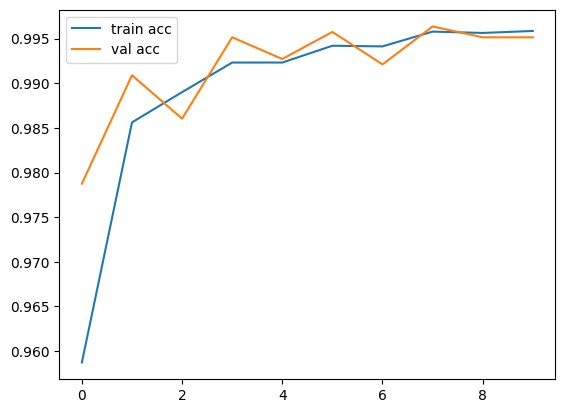

<Figure size 640x480 with 0 Axes>

In [66]:
model.save('vgg16_model_mask_detection_3_class.h5')


#loss
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

#accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [67]:
#Thử lại với 200 ảnh ngẫu nhiên
import os
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np
model = keras.models.load_model('./vgg16_model_mask_detection_3_class.h5')
num_test = 200
correct = 0
Choices = ["IncorrectMask", "WithMask", "WithoutMask"]
Incorrect = []
Name = [[]] * len(Choices)
for i in range(len(Choices)):
    Name[i] = os.listdir(os.path.expanduser('./Last_step/' + Choices[i]))
for _ in range(num_test):
    choice = np.random.randint(0, len(Choices))
    img_id = np.random.randint(1, len(Name[choice]))
    load_image = image.load_img('./Last_step/' + Choices[choice] + '/' + Name[choice][img_id], target_size=INPUT_SIZE)
    #load_image = load_image.convert('L')
    test_image = image.img_to_array(load_image)
    test_image_below1 = test_image/255
    test_image = np.expand_dims(test_image_below1, axis = 0)
    result = model.predict(test_image)
    result = result[0]
    result = np.argmax(result)
    ###
    T = False if choice != result else True
    correct += 1 if T else 0
    if not T:
        Incorrect.append((test_image_below1, Name[choice][img_id]))
    print("Case", _, ":", Choices[choice], Name[choice][img_id], "->", "Correct" if T else "Incorrect")
print("Correct:", correct, "/", num_test)

Incorrect_num = num_test - correct
print("Incorrect:", Incorrect_num)

fig = plt.figure(figsize=(10, 7))
rows = Incorrect_num
columns = 1
for i in range(rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(Incorrect[i][0])
    plt.title(Choices[choice] + "/" + Incorrect[i][1])


1/1 [==============================] - 0s 106ms/step
Case 0 : WithMask Augmented_106_6675239.png -> Correct
1/1 [==============================] - 0s 18ms/step
Case 1 : WithoutMask 394.png -> Correct
1/1 [==============================] - 0s 19ms/step
Case 2 : IncorrectMask 50323.png -> Correct
1/1 [==============================] - 0s 19ms/step
Case 3 : WithoutMask 5116.png -> Correct
1/1 [==============================] - 0s 19ms/step
Case 4 : WithoutMask 5116.png -> Correct
1/1 [==============================] - 0s 18ms/step
Case 5 : IncorrectMask 50264.png -> Correct
1/1 [==============================] - 0s 22ms/step
Case 6 : WithoutMask 3349.png -> Correct
1/1 [==============================] - 0s 20ms/step
Case 7 : WithMask Augmented_866_708286.png -> Correct
1/1 [==============================] - 0s 21ms/step
Case 8 : IncorrectMask 50427.png -> Correct
1/1 [==============================] - 0s 19ms/step
Case 9 : WithMask Augmented_863_5258905.png -> Correct
1/1 [===============

<Figure size 1000x700 with 0 Axes>